<a href="https://colab.research.google.com/github/hajink/ML/blob/main/Copy_of_CP2_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2.s997 2022 Challenge Problem 2: Generating Constraint-Aware Topologies**
In this Challenge Problem, your goal is to train a deep generative model to synthesize new structural topologies based on a dataset. However, your data has been hacked! You will need to train your generative model to recreate unknown missing sections of the dataset. Additionally, you will need to observe a set of unknown design constraints. Your only hint about the nature of these constraints is a dataset of constraint-violating ("invalid") topologies. 

Fig. 1: Sample topologies from the dataset

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/CP2%202022/16.png" height="230px">

**Dataset Generation:** The topologies have been generated using Topology Optimization using a loading and constraint setup as shown below:

Fig. 2: Topology Optimization Setup

<img src="http://decode.mit.edu/assets/images/problem.png" height="300px">

Fig. 3: Deflection under load of two example topologies

<img src="https://drive.google.com/uc?export=view&id=1XrWzE2wy8U0VnHORk5UUal5aGMsnQq5X" height="250px">



**Starter Code:** In this notebook, we have provided you with a working Generative Adversarial Network model for the 2.s997 Challenge Problem 2. It will help familiarize you with the task and get you going as you develop and test out your own implementation. 



### **Setting Things Up**

Before anything, make a copy of this notebook somewhere in your google drive. You will have to do this to be allowed to save changes to the code. 

<font color='red'>**To do: Go to the File menu on the top bar and select "Save a copy in Drive**".

Now you are ready to set things up.

To get you started, we have provided a simple working code on Google Colab for this problem which lets you going instantly and does not require you to install software libraries. All the files and code here will also be useful if you do not wish to use Google Colab and want to set up your programming environment and use other methods. 

<font color='red'>**To do: Make sure to use GPU when running on colab. To enable GPU, go to the "Runtime" menu above and select the "Change runtime type" option and select GPU. This will speed up the training significantly.**

To get started, you need to access the dataset and files. You can find all of the files and data using the link below:

 
### **[Project Files](https://drive.google.com/drive/folders/1hE3wPw6fWLj0STSds3nIB7HvXQOmhiN7?usp=sharing)**

 

For colab to gain access to these files make sure to first login to your Google account. 

<font color='red'>**To do: Once your logged in click on the link above. 
Once you are there, click on the folder name on the top bar and select add shortcut to drive:**

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/CP2%20Images/Snip1.png">

After this just make sure My Drive is highlighted and click the Add Shortcut botton:

<img src="https://raw.githubusercontent.com/Lyleregenwetter/2.s997-Demo-Materials/main/CP2%20Images/Snip2.png">

That's it we're ready to move on to coding!

**Loading Data:** Let's kick things off by importing some packages, mounting our drive to get access to the data, then loading the data up. We've given you four pieces of data:  One set of valid topologies and one set of invalid topologies, as well as a corresponding set of deflections for the valid topologies and invalid topologies, respectively. We'll just load up the valid data for now. 

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from matplotlib import image
from tqdm import tqdm
from google.colab import drive
import random

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
X_valid = np.load('./drive/MyDrive/Challenge Problem 2/data/Topologies_valid.npy')
Y_valid = np.load('./drive/MyDrive/Challenge Problem 2/data/Deflections_valid.npy')

**Explore Data:** Let's examine the data. We print the shapes of X_valid and Y_valid and plot a few random topologies. Observe that we have given you 3286 valid topologies and each is represented as a 40x120 black and white image. 

Shape of Valid Topology Data:  (3286, 40, 120)
Shape of Valid Deflection Data:  (3286,)


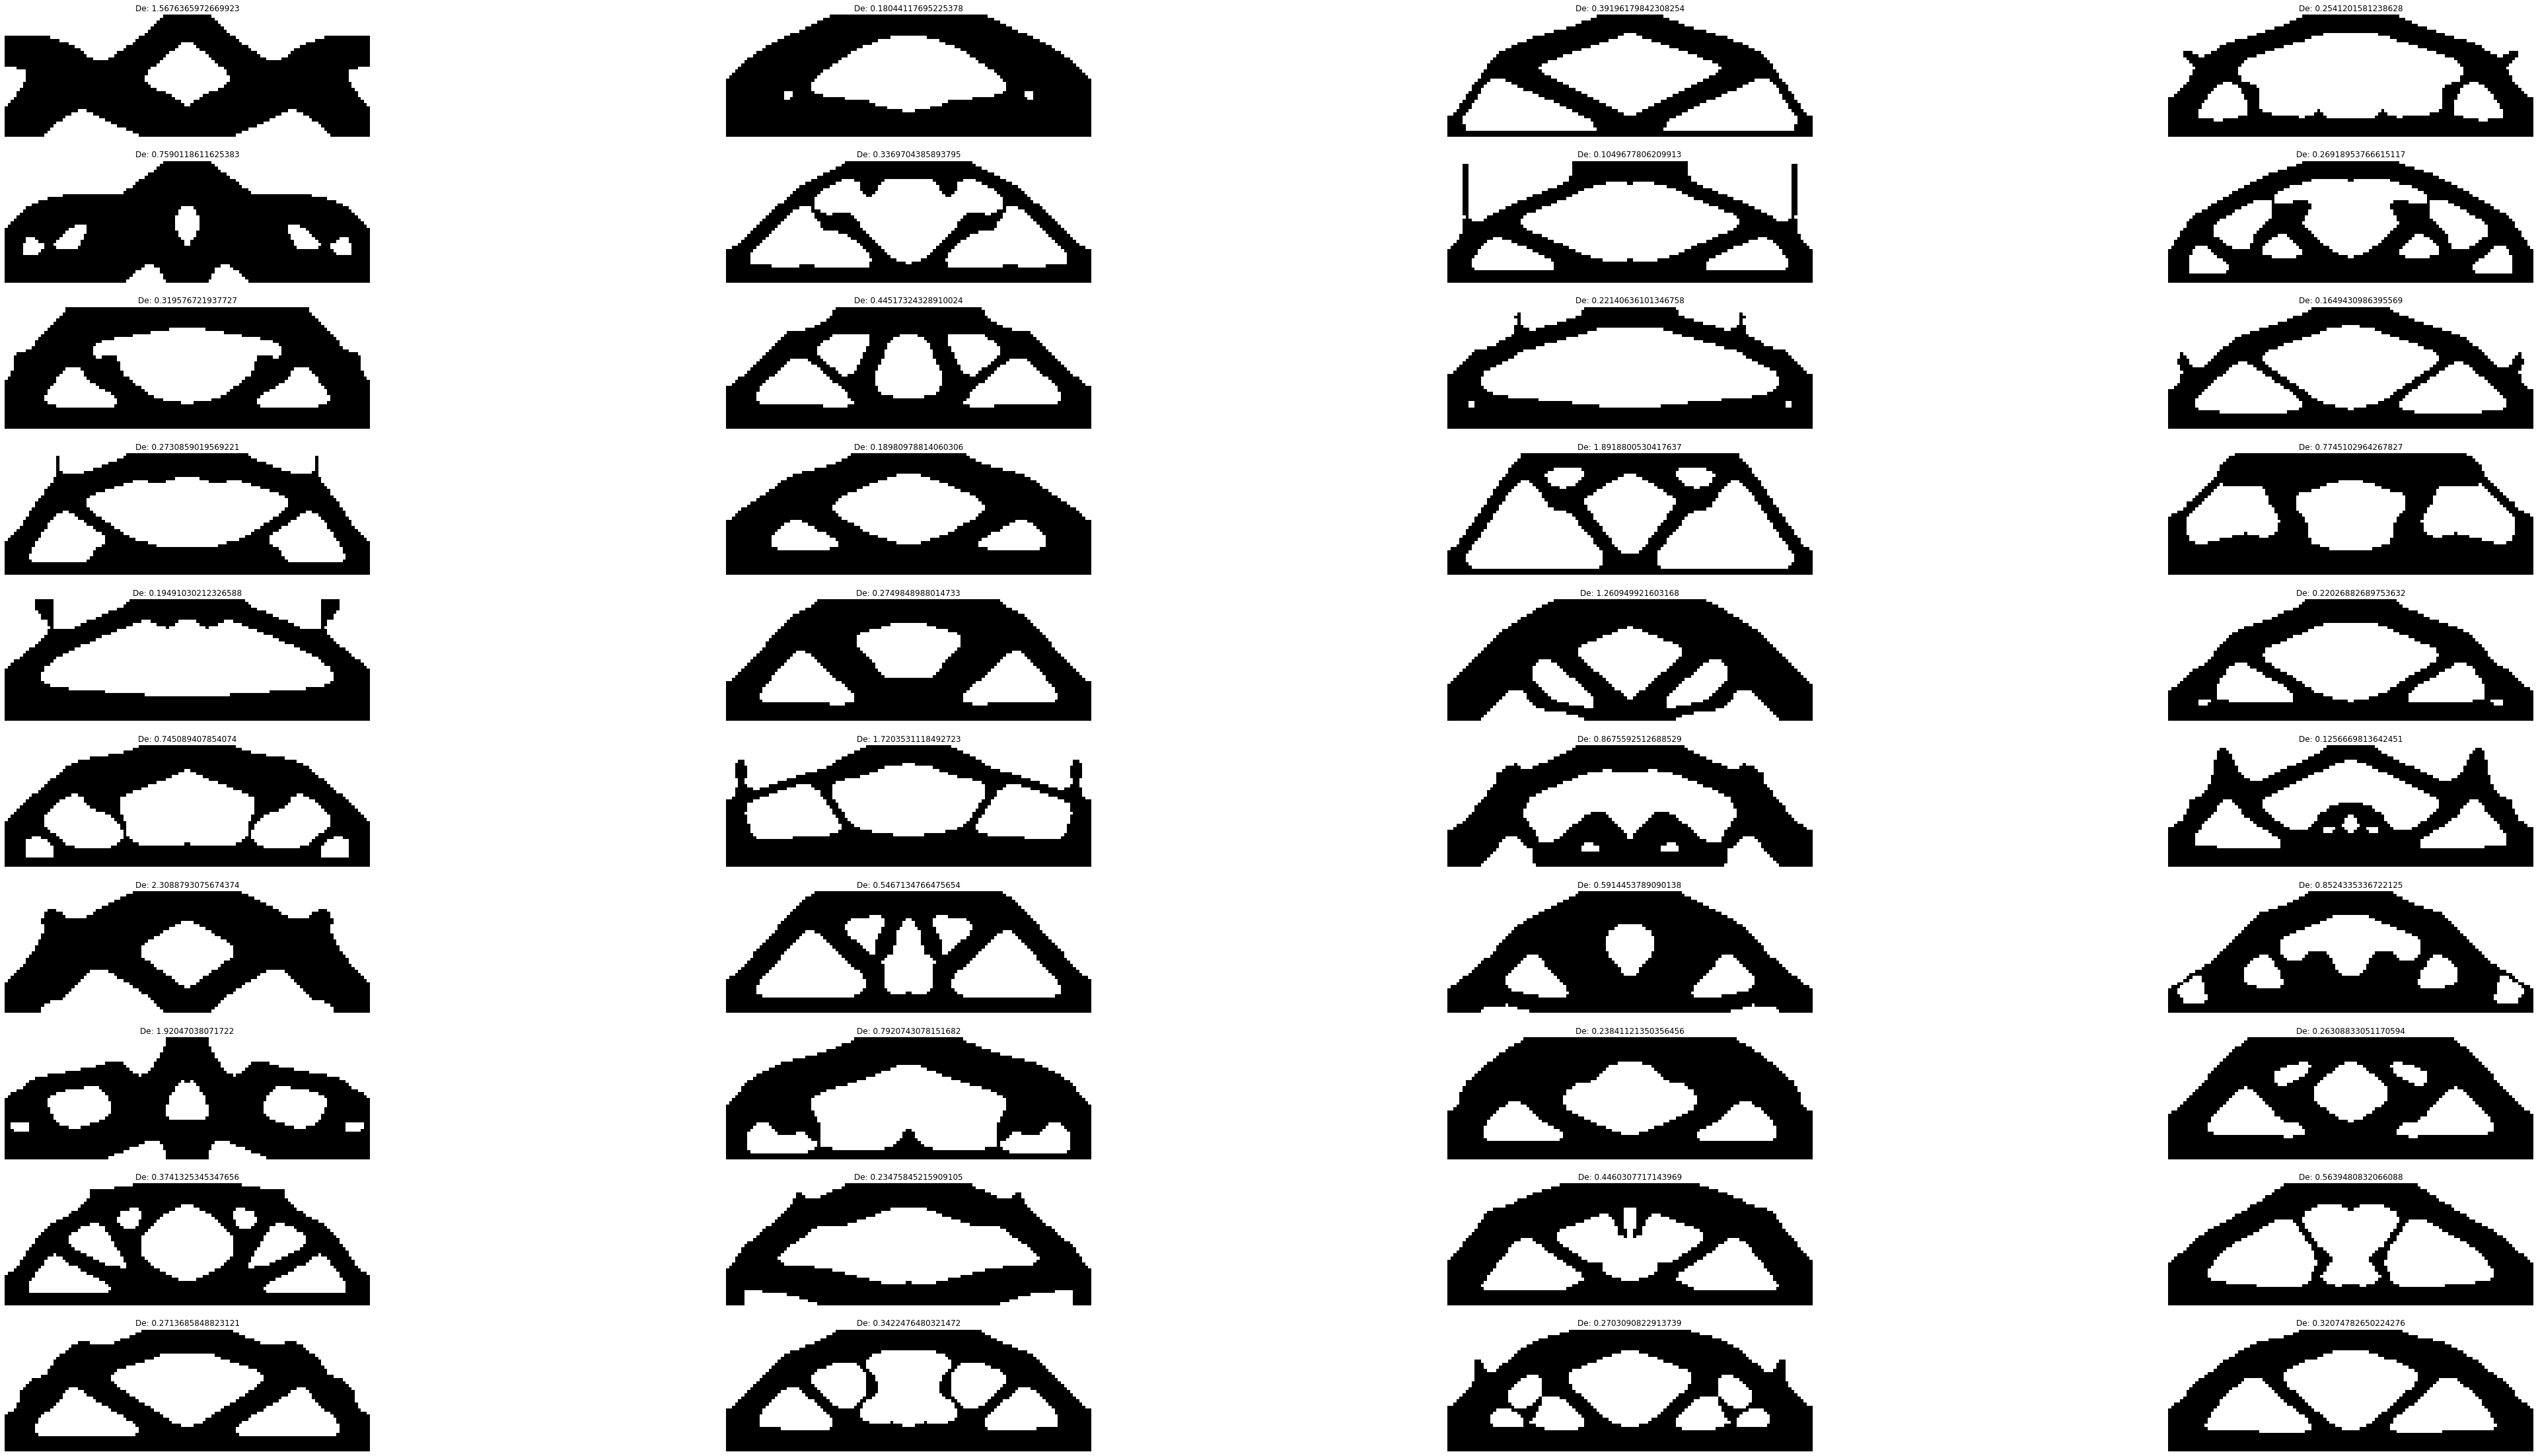

In [4]:
print('Shape of Valid Topology Data: ', np.shape(X_valid))
print('Shape of Valid Deflection Data: ', np.shape(Y_valid))

#Define a plotting function to plot topologies
def plot16(images, displacements=None):
    r = random.sample(range(len(images)), 16)
    fig = plt.figure(figsize=(25, 10))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        ax.axis('off')
        if not displacements is None:
          plt.title(f"De: {displacements[r[i]]}")
        plt.imshow(images[r[i]], cmap="gray_r")
    plt.show()

    #Define a plotting function to plot topologies
## Hajin adds: plot more than 16 pls
def plotMore(images, displacements=None):
    r = random.sample(range(len(images)), 40)
    fig = plt.figure(figsize=(3*25, 4*10))
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        ax.axis('off')
        if not displacements is None:
          plt.title(f"De: {displacements[r[i]]}")
        plt.imshow(images[r[i]], cmap="gray_r")
    plt.show()
    
plotMore(X_valid, Y_valid)

Now let's load and plot some of the invalid topologies. We provide you just 1641 of them. Why are these invalid? Can you guess some of our validity constraints?

Shape of Invalid Topology Data:  (1641, 40, 120)
Shape of Invalid Deflection Data:  (1641,)


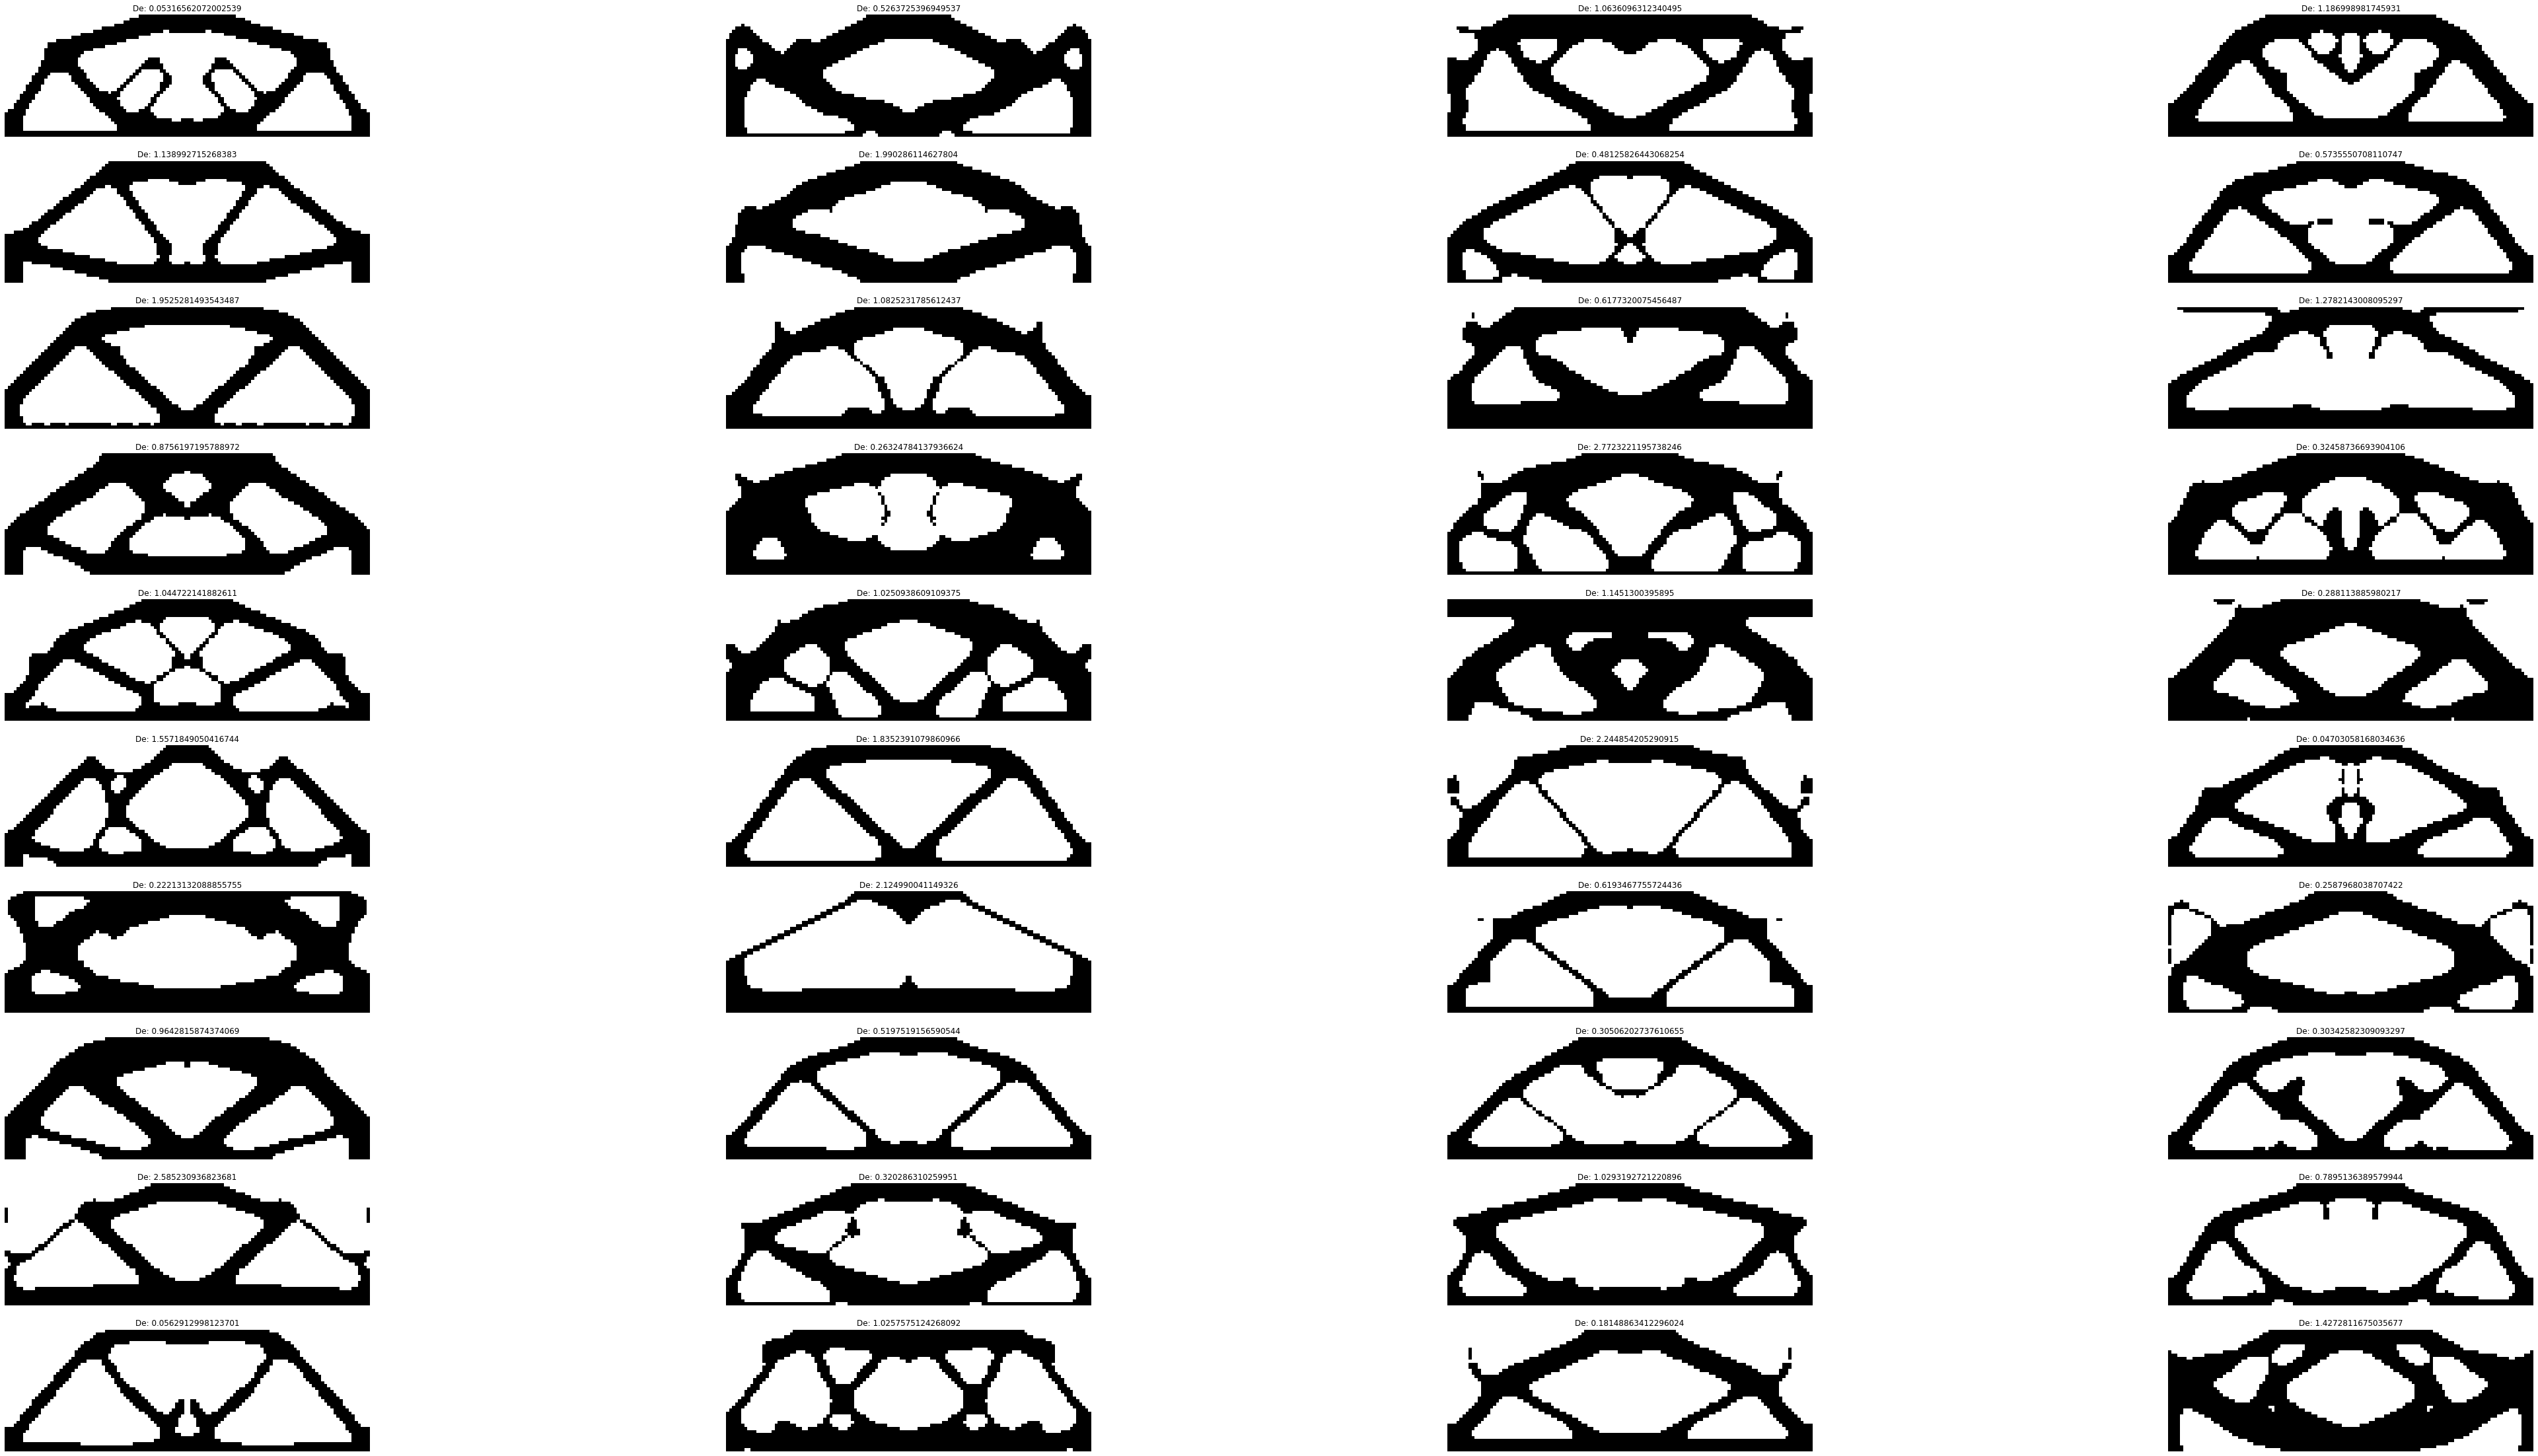

In [5]:
X_invalid = np.load('./drive/MyDrive/Challenge Problem 2/data/Topologies_invalid.npy')
Y_invalid = np.load('./drive/MyDrive/Challenge Problem 2/data/Deflections_invalid.npy')
print('Shape of Invalid Topology Data: ', np.shape(X_invalid))
print('Shape of Invalid Deflection Data: ', np.shape(Y_invalid))


plotMore(X_invalid, Y_invalid)

**Visualizing "Hacked" Data:** So what's wrong with the data? How did it get hacked? Let's dig a bit deeper and calculate the volume fraction for each topology. Then we'll make a scatterplot of displacement vs volume fraction. 

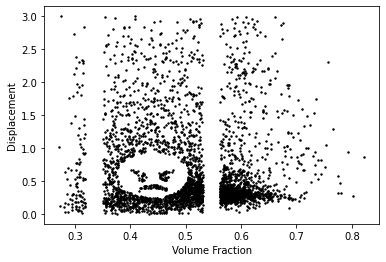

In [6]:
num_datapoints, height, width = np.shape(X_valid)

#Create array which will hold the volume fraction values
VF=np.zeros(num_datapoints)
for i in range(num_datapoints):
    #Sum the number of filled pixels then divide by total pixels
    VF[i] = np.sum(X_valid[i,:,:])/(height*width)

#Make scatterplot
plt.scatter(VF,Y_valid, s=2, alpha=1, c="k")
plt.xlabel("Volume Fraction")
plt.ylabel("Displacement")
plt.show()

Oh no! It looks like someone has hacked your data and selectively deleted topologies from your dataset and left an evil frowny face on your data as some kind of cringey hacker tag! But more importantly, they have deleted entire swathes of designs with Volume Fractions in particular ranges. This will pose a challenge for your model! How will it know how to generate topologies with certain volume fractions without seeing example topologies in the dataset with similar volume fractions? The dataset has also been modified in other ways besides what we have shown here. 

For simplicity, we won't really be using the displacement values for this Challenge Problem moving forward. However, in a real problem, you would very much care about the performance of your generated topologies and could leverage displacement values to enable performance-aware generation. 

# **Starter Code**

**GAN Class:** We provide you with a working GAN implementation. Note that this GAN does not leverage the dataset of invalid samples in any way and is only trained on the dataset of valid samples. This is a lot of code, but we've tried to document it very well. If you really want to understand GANs, we recommend sitting down with this code and understanding what each line is doing conceptually. 

In [7]:
class imGAN:
    def __init__(self, imdims, noise_dim):
        self.dim_x = imdims #Dimensionality of the images
        self.noise_dim = noise_dim #Dimensionality of the latent (noise) vectors (can tune)
        
    def create_models(self):
        #Call our class functions to build the generator and discriminator networks
        self.generator = self.create_generator()
        self.discriminator = self.create_discriminator()

        #Set the optimizers for generator and discriminator. Optimizer parameters can be tuned
        self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
        self.d_optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, beta_2=0.9)
        
    def print_model_summary(self):
        #Prints model summaries for the generator an descriminator
        self.generator.summary()
        self.discriminator.summary()

    # Class function to build a Standard Convolutional Neural Network for the discriminator     
    def create_discriminator(self):
        # We create a keras sequential model and add layers one by one
        model = tf.keras.Sequential(name='discriminator')
        model.add(tf.keras.layers.InputLayer(input_shape=self.dim_x))
        
        #First convolution layer
        model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Second convolution layer
        model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Third convolution layer
        model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=3, strides=2))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Flatten the output of the convolutional layers
        model.add(tf.keras.layers.Flatten())
        
        #First Dense Layer of size 20
        model.add(tf.keras.layers.Dense(20))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU())
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Dense layer with single output
        model.add(tf.keras.layers.Dense(1))
        #We do not need an activation function here since we will calculate the cross entropy loss from logits

        #Return the model
        return model
    
    # Class function to build a Standard Convolution Transpose Neural Network for the generator 
    def create_generator(self):
        # We create a keras sequential model and add layers one by one
        model = tf.keras.Sequential(name='generator')
        model.add(tf.keras.layers.InputLayer(input_shape=(self.noise_dim,)))

        #Dense layer. Maps our noise_dim dimensional layer to a 4800 dimensional vector
        model.add(tf.keras.layers.Dense(10*30*16))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.1))
        
        #reshape our 4800 dimensional vector into a 16 5x15 images
        model.add(tf.keras.layers.Reshape(target_shape=(10, 30, 16))) 

        #First Conv2DTranspose. We apply padding here since we want a 10x30 dimesional output
        model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=1, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Second Conv2DTranspose. We apply padding here since we want a 20x60 dimesional output
        model.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Third Conv2DTranspose. We apply padding here since we want a 40x120 dimesional output
        model.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.LeakyReLU(alpha=0.2))
        model.add(tf.keras.layers.Dropout(0.1))
        
        #Conv2D layer with sigmoid activation function for output of the generator
        model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=5, strides=1, padding='same',activation='sigmoid'))

        #Return the model
        return model

    #Define a Tensorflow Function for the training step
    @tf.function
    def train_step(self, X_real):
        #Make local variables for several class variables for convenience
        generator = self.generator
        discriminator = self.discriminator
        g_optimizer = self.g_optimizer
        d_optimizer = self.d_optimizer
        noise_dim = self.noise_dim
        
        #Define our binary cross entropy loss function for convenience
        binary_cross_entropy_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

        #Define batch size foe convenience
        batch_size = tf.shape(X_real)[0]

        #Sample a noise vector from a multivariate gaussian distribution
        z = tf.random.normal(shape=(batch_size, noise_dim))

        #Feed noise vector into the generator to get a fake (generated) image
        X_fake = generator(z, training=False)

        #Calculate discriminator loss inside a gradient tape
        with tf.GradientTape() as tape:
            #Call the discriminator on a real image
            d_real = discriminator(X_real)

            #Calculate a cross entropy loss based on how different the discriminator's predictions are to a vector of all ones
            d_loss_real = binary_cross_entropy_loss_fn(tf.ones_like(d_real),d_real)

            #Call the discriminator on a fake (generated) image
            d_fake = discriminator(X_fake)

            #Calculate a cross entropy loss based on how different the discriminator's predictions are to a vector of all zeroes
            d_loss_fake = binary_cross_entropy_loss_fn(tf.zeros_like(d_fake),d_fake)

            #Total discriminator loss is the sum of the two
            d_loss = (d_loss_fake + d_loss_real)

        #Calculate and apply gradients to the trainable weights of the discriminator
        variables = discriminator.trainable_weights
        gradients = tape.gradient(d_loss, variables)
        d_optimizer.apply_gradients(zip(gradients, variables))

        #Sample a noise vector from a multivariate gaussian distribution
        z = tf.random.normal(shape=(batch_size, noise_dim))

        #Calculate generator loss inside a gradient tape
        with tf.GradientTape() as tape:
            #Feed noise vector into the generator to get a fake (generated) image
            x_fake_train = generator(z)

            #Get the discriminator's assessment of the fake image
            d_fake = discriminator(x_fake_train)

            #Calculate a cross entropy loss based on how different the discriminator's predictions are to a vector of all ones
            g_loss = binary_cross_entropy_loss_fn(tf.ones_like(d_fake),d_fake)

        #Calculate and apply gradients to the trainable weights of the generator
        variables = generator.trainable_weights
        gradients = tape.gradient(g_loss, variables)
        g_optimizer.apply_gradients(zip(gradients, variables))

        #Return losses to print out later
        return d_loss_real, d_loss_fake, g_loss
    
    #GAN Training Function
    def train(self, dataset, checkpoint_dir, epochs=200):
        for epoch in range(epochs):
            #Plot one generated image so we can monitor training
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            generated_images = self.generator(noise, training=False)
            plt.imshow(np.squeeze(generated_images[0]), cmap="gray_r")
            plt.show()

            #Initialize some variables to sum up the total losses
            DLRtot=0
            DLFtot = 0
            GLtot=0

            #Count number of batches
            numbatches=0

            #Set up progress bar object
            r = tqdm(dataset)

            #Loop over the batches
            for batch in r:
                numbatches+=1

                #Call train step function here and return losses
                DLR, DLF, GL = self.train_step(batch)
                DLRtot+=DLR
                DLFtot+=DLF
                GLtot+=GL

                #Update progress bar
                r.set_postfix_str("Gen Loss:" + str(GL.numpy()) + ", Disc Loss Real: " + str(DLR.numpy()) + ", Disc Loss Fake: " + str(DLF.numpy()))
            GLtot=GLtot/numbatches
            DLtot=(DLRtot+DLFtot)/2/numbatches

            # Save the model every 15 epochs
            if checkpoint_dir:
                checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer, discriminator_optimizer=self.d_optimizer,generator = self.generator, discriminator = self.discriminator)
                if (epoch + 1) % 15 == 0:
                    checkpoint.save(file_prefix = checkpoint_dir)
                print("Epoch " + str(epoch) +  ", Gen Loss: " + str(float(GLtot)) + ", Disc Loss: " + str(float(DLtot)))

    #Function to generate topologies
    def generate(self, num_gen = 1000):
        count = 0
        #In order to avoid running out of momery, we need to do this in a loop
        while count<num_gen:

            #Sample a noise vector from a multivariate gaussian distribution and generate
            z = tf.random.normal(shape=(BATCH_SIZE, noise_dim))
            if count==0:
                X_fake = self.generator(z, training=False)
            else:
                X_fake = np.concatenate((X_fake, GAN.generator(z, training=False)), axis=0)
            count+=BATCH_SIZE 
        X_fake=X_fake[:num_gen]

        #Threshold generated images to convert to black and white over a cutoff of 0.5
        X_fake = tf.cast(tf.math.greater(X_fake[:,:,:,0], 0.5), "int64") 

        #Convert to numpy array and return
        return X_fake.numpy()

**Training:** We split off 100 samples to use as training data and train the GAN using the rest:

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4800)              158400    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4800)              0         
                                                                 
 dropout (Dropout)           (None, 4800)              0         
                                                                 
 reshape (Reshape)           (None, 10, 30, 16)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 30, 128)      18560     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 30, 128)      512       
 ormalization)                                           

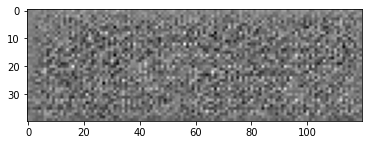

100%|██████████| 100/100 [00:07<00:00, 12.81it/s, Gen Loss:2.260364, Disc Loss Real: 0.15796572, Disc Loss Fake: 0.3081684]

Epoch 0, Gen Loss: 1.2550880908966064, Disc Loss: 0.3096698820590973


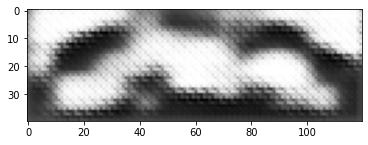

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:0.7349317, Disc Loss Real: 0.7049431, Disc Loss Fake: 0.5386012]

Epoch 1, Gen Loss: 1.0972728729248047, Disc Loss: 0.5426722168922424


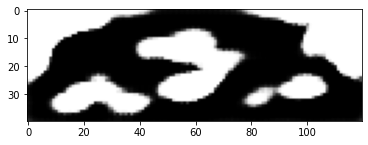

100%|██████████| 100/100 [00:05<00:00, 19.51it/s, Gen Loss:0.676183, Disc Loss Real: 1.0719737, Disc Loss Fake: 0.42085546]


Epoch 2, Gen Loss: 0.8258979320526123, Disc Loss: 0.6600598096847534


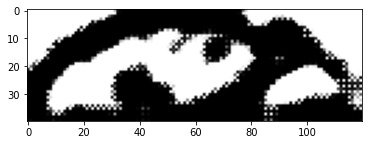

100%|██████████| 100/100 [00:03<00:00, 25.00it/s, Gen Loss:1.0334866, Disc Loss Real: 0.5834122, Disc Loss Fake: 0.7153044]


Epoch 3, Gen Loss: 0.8001508116722107, Disc Loss: 0.6583677530288696


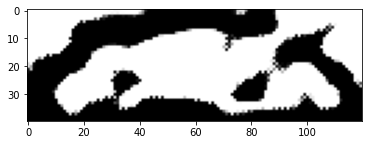

100%|██████████| 100/100 [00:05<00:00, 19.58it/s, Gen Loss:1.641989, Disc Loss Real: 0.52907044, Disc Loss Fake: 0.88766265]

Epoch 4, Gen Loss: 0.8302029967308044, Disc Loss: 0.6523873805999756


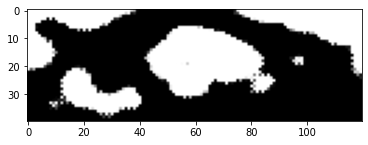

100%|██████████| 100/100 [00:05<00:00, 19.57it/s, Gen Loss:0.71887374, Disc Loss Real: 0.6114832, Disc Loss Fake: 0.63510716]

Epoch 5, Gen Loss: 0.8014001250267029, Disc Loss: 0.6692773699760437


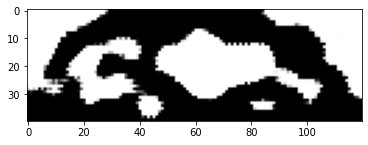

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:1.1041238, Disc Loss Real: 0.5324772, Disc Loss Fake: 0.7224993]

Epoch 6, Gen Loss: 0.8209599852561951, Disc Loss: 0.642963171005249


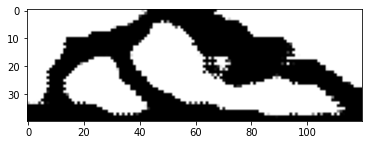

100%|██████████| 100/100 [00:05<00:00, 19.48it/s, Gen Loss:0.94467473, Disc Loss Real: 0.51866925, Disc Loss Fake: 0.6755263]

Epoch 7, Gen Loss: 0.8291982412338257, Disc Loss: 0.6357515454292297


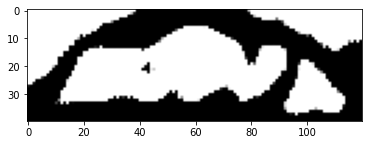

100%|██████████| 100/100 [00:05<00:00, 19.52it/s, Gen Loss:0.7780166, Disc Loss Real: 0.60862285, Disc Loss Fake: 0.6650365]

Epoch 8, Gen Loss: 0.8307043313980103, Disc Loss: 0.6413276791572571


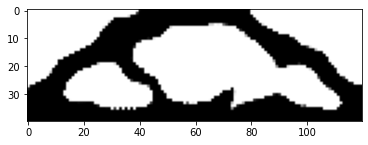

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:1.329713, Disc Loss Real: 0.5690872, Disc Loss Fake: 0.7190151]

Epoch 9, Gen Loss: 0.811210036277771, Disc Loss: 0.6560472249984741


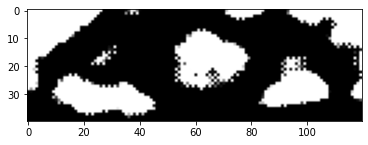

100%|██████████| 100/100 [00:03<00:00, 25.49it/s, Gen Loss:0.79036266, Disc Loss Real: 0.6152872, Disc Loss Fake: 0.58381957]


Epoch 10, Gen Loss: 0.8272531032562256, Disc Loss: 0.6286174058914185


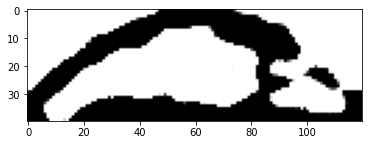

100%|██████████| 100/100 [00:03<00:00, 25.48it/s, Gen Loss:0.87262934, Disc Loss Real: 0.84575737, Disc Loss Fake: 0.4591501]


Epoch 11, Gen Loss: 0.8157605528831482, Disc Loss: 0.6451241970062256


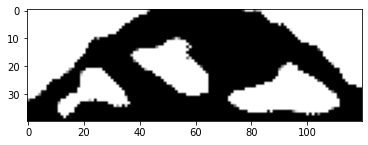

100%|██████████| 100/100 [00:03<00:00, 25.25it/s, Gen Loss:1.2042409, Disc Loss Real: 0.36034462, Disc Loss Fake: 0.97476643]


Epoch 12, Gen Loss: 0.8126943111419678, Disc Loss: 0.6343232989311218


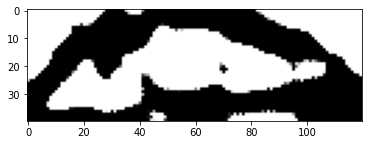

100%|██████████| 100/100 [00:05<00:00, 19.50it/s, Gen Loss:1.043469, Disc Loss Real: 0.56580305, Disc Loss Fake: 0.5242628]

Epoch 13, Gen Loss: 0.8390898704528809, Disc Loss: 0.6262840032577515


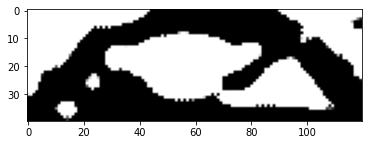

100%|██████████| 100/100 [00:04<00:00, 24.76it/s, Gen Loss:1.0996184, Disc Loss Real: 0.4650601, Disc Loss Fake: 0.77607346]


Epoch 14, Gen Loss: 0.8366953134536743, Disc Loss: 0.6260806918144226


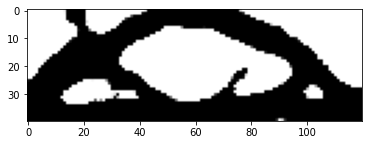

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:0.9159129, Disc Loss Real: 0.5099779, Disc Loss Fake: 0.7117382]

Epoch 15, Gen Loss: 0.8228711485862732, Disc Loss: 0.6315160393714905


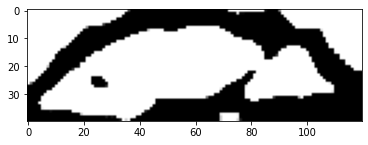

100%|██████████| 100/100 [00:03<00:00, 25.31it/s, Gen Loss:0.6864515, Disc Loss Real: 0.5703461, Disc Loss Fake: 0.57491726]


Epoch 16, Gen Loss: 0.8295787572860718, Disc Loss: 0.6255555748939514


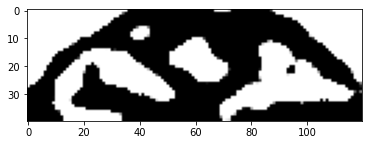

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:0.8087619, Disc Loss Real: 0.5954362, Disc Loss Fake: 0.5723438]

Epoch 17, Gen Loss: 0.837862491607666, Disc Loss: 0.6270838379859924


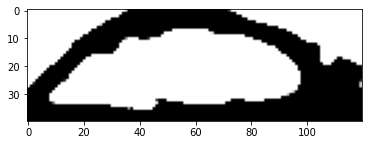

100%|██████████| 100/100 [00:05<00:00, 19.55it/s, Gen Loss:0.8868777, Disc Loss Real: 0.78085065, Disc Loss Fake: 0.40447038]

Epoch 18, Gen Loss: 0.840329110622406, Disc Loss: 0.6257999539375305


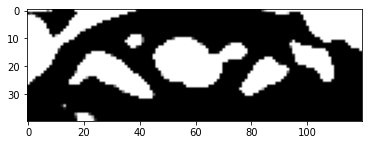

100%|██████████| 100/100 [00:05<00:00, 19.50it/s, Gen Loss:0.75596064, Disc Loss Real: 0.69011825, Disc Loss Fake: 0.49961042]

Epoch 19, Gen Loss: 0.8261276483535767, Disc Loss: 0.6348678469657898


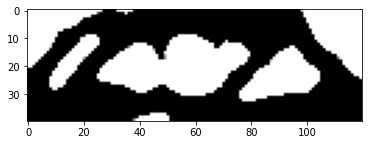

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:0.6174806, Disc Loss Real: 0.8545215, Disc Loss Fake: 0.4237323]

Epoch 20, Gen Loss: 0.8245072960853577, Disc Loss: 0.6293213367462158


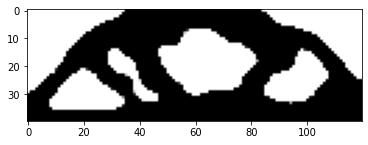

100%|██████████| 100/100 [00:03<00:00, 25.01it/s, Gen Loss:1.028177, Disc Loss Real: 0.4238872, Disc Loss Fake: 0.8074154]


Epoch 21, Gen Loss: 0.8414086699485779, Disc Loss: 0.629793107509613


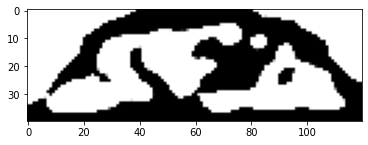

100%|██████████| 100/100 [00:05<00:00, 19.53it/s, Gen Loss:1.0824257, Disc Loss Real: 0.6179563, Disc Loss Fake: 0.61540514]

Epoch 22, Gen Loss: 0.8264094591140747, Disc Loss: 0.6293060183525085


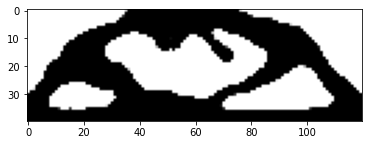

100%|██████████| 100/100 [00:04<00:00, 24.72it/s, Gen Loss:1.1806289, Disc Loss Real: 0.39720848, Disc Loss Fake: 0.85408133]


Epoch 23, Gen Loss: 0.8520892858505249, Disc Loss: 0.6226427555084229


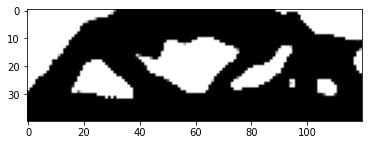

100%|██████████| 100/100 [00:05<00:00, 19.50it/s, Gen Loss:0.8037734, Disc Loss Real: 0.6835758, Disc Loss Fake: 0.5920008]


Epoch 24, Gen Loss: 0.8394364714622498, Disc Loss: 0.6197344064712524


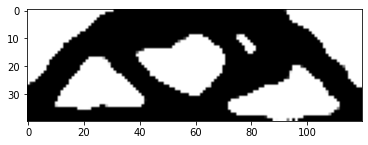

100%|██████████| 100/100 [00:05<00:00, 19.59it/s, Gen Loss:0.85008174, Disc Loss Real: 0.47233507, Disc Loss Fake: 0.667794]

Epoch 25, Gen Loss: 0.8436537981033325, Disc Loss: 0.6199959516525269


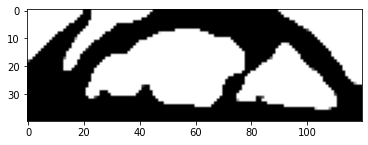

100%|██████████| 100/100 [00:05<00:00, 19.51it/s, Gen Loss:0.9894015, Disc Loss Real: 0.3914472, Disc Loss Fake: 0.826874]

Epoch 26, Gen Loss: 0.8511596918106079, Disc Loss: 0.6182864308357239


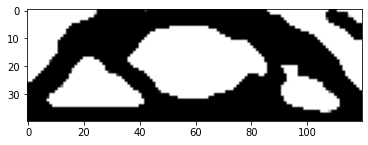

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:1.1791298, Disc Loss Real: 0.38793644, Disc Loss Fake: 0.8154348]

Epoch 27, Gen Loss: 0.8635077476501465, Disc Loss: 0.6108709573745728


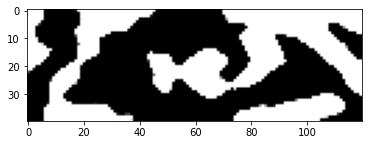

100%|██████████| 100/100 [00:05<00:00, 19.48it/s, Gen Loss:1.0732427, Disc Loss Real: 0.6570897, Disc Loss Fake: 0.5197565]

Epoch 28, Gen Loss: 0.8868245482444763, Disc Loss: 0.6084774136543274


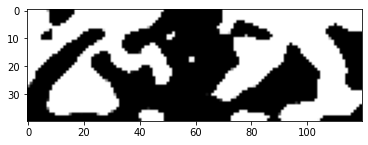

100%|██████████| 100/100 [00:05<00:00, 19.59it/s, Gen Loss:0.8076643, Disc Loss Real: 0.54786676, Disc Loss Fake: 0.54215246]


Epoch 29, Gen Loss: 0.8756272792816162, Disc Loss: 0.6044222116470337


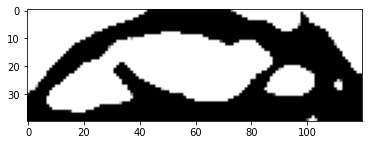

100%|██████████| 100/100 [00:05<00:00, 19.56it/s, Gen Loss:1.1651549, Disc Loss Real: 0.47393382, Disc Loss Fake: 0.692783]

Epoch 30, Gen Loss: 0.8908318281173706, Disc Loss: 0.5942699909210205


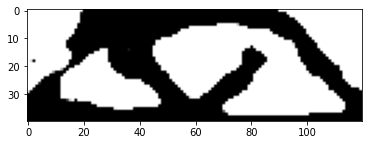

100%|██████████| 100/100 [00:04<00:00, 24.68it/s, Gen Loss:1.1191162, Disc Loss Real: 0.35972416, Disc Loss Fake: 0.7295716]


Epoch 31, Gen Loss: 0.9077096581459045, Disc Loss: 0.5886232256889343


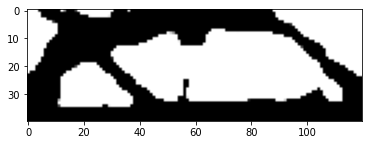

100%|██████████| 100/100 [00:04<00:00, 24.78it/s, Gen Loss:1.1801057, Disc Loss Real: 0.36256394, Disc Loss Fake: 0.7634487]


Epoch 32, Gen Loss: 0.9128650426864624, Disc Loss: 0.5812724232673645


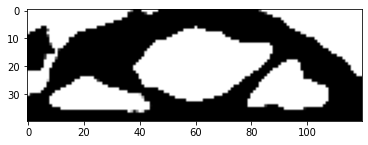

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:1.1544263, Disc Loss Real: 0.3372594, Disc Loss Fake: 0.71241564]

Epoch 33, Gen Loss: 0.9207441806793213, Disc Loss: 0.5796127915382385


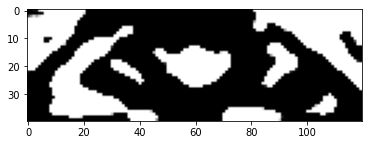

100%|██████████| 100/100 [00:05<00:00, 19.51it/s, Gen Loss:1.038452, Disc Loss Real: 0.36352834, Disc Loss Fake: 0.5768829]


Epoch 34, Gen Loss: 0.9505509734153748, Disc Loss: 0.5665193200111389


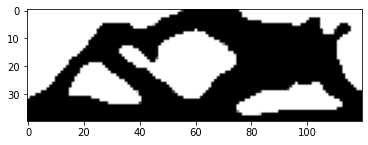

100%|██████████| 100/100 [00:05<00:00, 19.53it/s, Gen Loss:0.8902276, Disc Loss Real: 0.5156501, Disc Loss Fake: 0.4019419]

Epoch 35, Gen Loss: 0.9566574096679688, Disc Loss: 0.5621986985206604


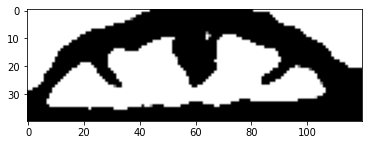

100%|██████████| 100/100 [00:05<00:00, 19.52it/s, Gen Loss:1.1905737, Disc Loss Real: 0.32809144, Disc Loss Fake: 0.6449762]

Epoch 36, Gen Loss: 0.9725436568260193, Disc Loss: 0.5549702644348145


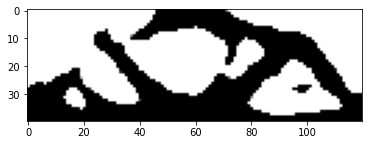

100%|██████████| 100/100 [00:04<00:00, 24.75it/s, Gen Loss:0.9928658, Disc Loss Real: 0.4688299, Disc Loss Fake: 0.51576227]


Epoch 37, Gen Loss: 0.982164740562439, Disc Loss: 0.5506616830825806


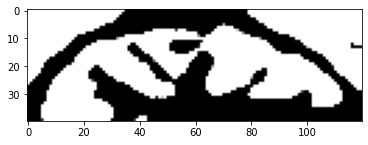

100%|██████████| 100/100 [00:05<00:00, 19.50it/s, Gen Loss:1.1798686, Disc Loss Real: 0.43741167, Disc Loss Fake: 0.487998]

Epoch 38, Gen Loss: 1.0113301277160645, Disc Loss: 0.5408521890640259


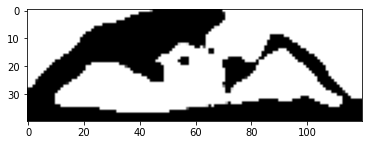

100%|██████████| 100/100 [00:05<00:00, 19.60it/s, Gen Loss:1.5661432, Disc Loss Real: 0.28950128, Disc Loss Fake: 0.6984499]

Epoch 39, Gen Loss: 1.0309031009674072, Disc Loss: 0.5315227508544922


In [8]:
noise_dim = 32
BATCH_SIZE = 32

#Split off 100 samples for validation
Xtraining, Xvalidation = train_test_split(X_valid, test_size=100)

#Tensorflow expects mult-channel images, so we add a dimension for color channels, but only use one.
Xtraining = tf.expand_dims(Xtraining, -1)

#Get the dimensions of the images
image_dimensions=np.shape(Xtraining[0])

#Batch the data
image_train_batched=tf.data.Dataset.from_tensor_slices(Xtraining).batch(BATCH_SIZE)
image_val_batched=tf.data.Dataset.from_tensor_slices(Xtraining).batch(BATCH_SIZE)

#Create a GAN instance
GAN=imGAN(image_dimensions, noise_dim)

#Create the generator and discriminator models
GAN.create_models()

#Print a summary of the models
GAN.print_model_summary()

#Specify checkpoint directory for model checkpoints
checkpoint_dir = './GAN_checkpoints/ckpt'

#Train for 40 epochs
GAN.train(image_train_batched, checkpoint_dir, 40)

**Generation** Let's take a look at the topoligies that our GAN is generating. Let's generate and plot some topologies. Do you think these designs satisfy the constraints? How can you tell?

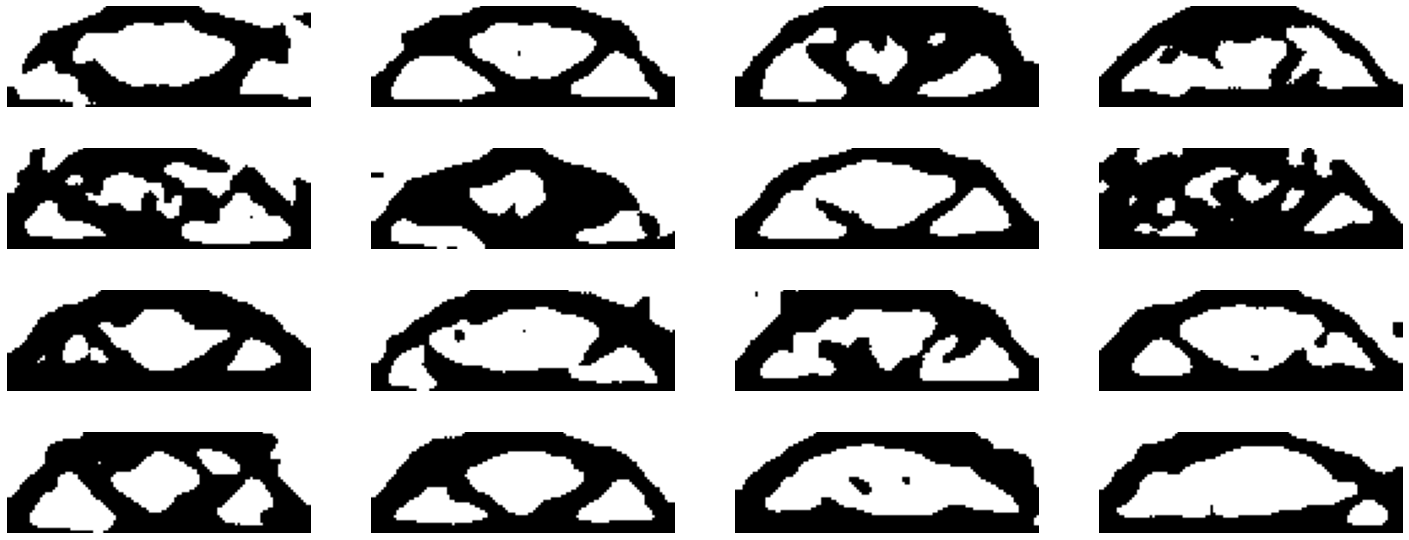

In [9]:
#Generate and plot 16 topologies
plot16(GAN.generate(16))

Let's see if our generated samples fill in the gaps in volume fraction from our original samples.

Text(0, 0.5, 'Count')

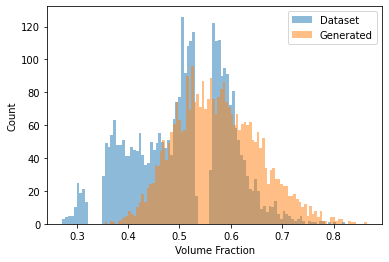

In [10]:
#Generate the same number of samples as in our dataset
g = GAN.generate(num_datapoints)

#Calculate volume fraction
VF_gen=np.zeros(num_datapoints)
for i in range(num_datapoints):
    VF_gen[i] = np.sum(g[i,:,:])/(height*width)

#Create histogram
plt.hist(VF, bins=100, alpha=0.5, label="Dataset")
plt.hist(VF_gen, bins=100, alpha=0.5, label="Generated")
plt.legend(loc='upper right')
plt.xlabel("Volume Fraction")
plt.ylabel("Count")

GAN training is quite unpredictable, however, its quite likely that our GAN will seem to have learned how to generate samples with volume fraction that were not seen in the dataset. 

**Scoring:** Let's generate a set of 1000 final topologies and calculate a score using the 100 samples that we split off from our training set. We use a bidirectional similarity metric using structural similarity index (SSIM) to measure the similarity of your generated distribution to the test distribution. For the first score component, we average the SSIM scores of each test topology's most similar VALID generated topology. For the second score component, we average the SSIM scores of each VALID generated topology's most similar test topology. If a generated topology is invalid, it automatically receives a similarity score of zero with any other topology. We then take the geometric mean of the two scoring components for a maximum score of 1 and a minimum score of 0. **Important:** Any invalid topologies will not be scored. 

In [11]:
#Generate 1000 topologies for the final submission
final_topologies = GAN.generate(1000)

In [12]:
def score_SSIM(t1, t2):
    #Partially vectorized SSIM calculation
    total=0
    t1=tf.cast(tf.expand_dims(t1, -1), "float")
    #Loop over images in t2
    for image in tqdm(t2):
        #Cast our images to floats and expand dimensions
        image=tf.cast(tf.expand_dims(image, -1), "float")
        image = tf.expand_dims(image, 0)

        #Duplicate image len(t2) times since we want to compare the image against every image in t2
        image = tf.repeat(image, len(t1), axis=0)

        #Calculate SSIM
        score = tf.image.ssim(image, t1, 1, filter_size=11)

        #Use best SSIM score (most similar image in t2)
        best = float(max(score))

        #Add to total
        total+=best
    return total
def final_score(gen, test):
    #Calculate the two components of the score and take geometric mean
    s1 = score_SSIM(gen,test)/100
    s2 = score_SSIM(test, gen)/1000
    return np.sqrt(s1*s2)

#Call scoring function on our generated topologies and our validation set
score = final_score(final_topologies, Xvalidation)


100%|██████████| 1000/1000 [00:56<00:00, 17.65it/s]


In [13]:
print(f"Validation Score: {score}")

Validation Score: 0.36617979074616275


**WARNING 1:** We have our own test set that was sampled from the original dataset BEFORE hacking. This means that we have test cases that are unlike the training data. Just because you have scored well on this validation set that you split off from the provided training data, does not mean you will score well on our actual test set. 

**WARNING 2:** If your generated samples are largely invalid, your actual score will be drastically lower. Handling constraints will improve your actual submission score, but will not impact your validation score in the notebook. 

**Submission:** Let's build a submission. We ask you to submit a file named "ID.npy" where ID is a 9 digit submission ID. It is important that every submission has an ID. We provide you a function to save your output with a random ID and recommend you use this. You will use your submission IDs to look up your scores on the test set. This npy file is either saved in your Google Drive's main folder, or to your current filetree. If working in colab, this will create a temporary file that you can find in the files panel in colab.

In [14]:
def build_submission(path, final_topologies):
    print(np.shape(final_topologies))
    assert np.shape(final_topologies)==(1000, 40, 120)
    random.seed()
    submissionID=random.randint(100000000, 999999999)
    np.save(path + str(submissionID) + ".npy", final_topologies)
    print("saving file " + str(submissionID) + ".npy to path " + path)
    
#Uncomment one of the two lines below depending on where you want your output saved
# build_submission("", final_topologies) #Use this to save to colab temp space or if working locally
build_submission("./drive/MyDrive/", final_topologies) #Use this to save to drive

(1000, 40, 120)
saving file 953795714.npy to path ./drive/MyDrive/


We will allow each team 5 submissions. Lyle will score your submission on our test set within 48 hours and update the scoreboard with a score report containing your final score and the number of invalid designs you submitted. If you would like your score to be anonymous, you may choose to submit using an anonymous pseudonym or leave the name field blank and look up your score using your submission ID.  

To submit please go to:
[Submission Form](https://docs.google.com/forms/d/e/1FAIpQLSe1uIc2sSpTCQX3PKaLmJyQC16CHD2HMFLcRVmvDRcKMZybrg/viewform?usp=sf_link)

To see the leaderboard you can go to:
[Leaderboard](https://decode.mit.edu/CP2/)